# Exercise 4

This week we will practice how to conduct data classification and aggregation using geopandas. Last week in exercise 3 we analyzed buffer zones around shopping centers. This week we will take into account travel distances using data from the [Helsinki Region Travel Time Matrix](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/).


## Problem 1: Join accessibility datasets into a grid and visualize the data on a map (10 points)


![P1 example result](img/traveltimes_example.png)

*Desired output from problem 1: Travel times by public transport (PT) and car to Itis and Myyrmanni*

**Data:**

The [data/](data/) directory in this repository contains all the required input data for this exercise:
 
- Travel time data: `travel_times_to_[XXXXXXX]_[NAME-OF-THE-CENTER].txt` (Travel times and distances in the Helsinki Region to different shopping centers  as text files)
- Reference grid: `MetropAccess_YKR_grid_EurefFIN.shp`. 

Column `from_id` in the travel time data sets corresponds to the `YKR_ID` column in the grid shapefile.
     
**Steps:**

In problem 1 we will focus on travel times to **Itis** and **Myyrmanni**. Our goal is to visualize travel times by public transport and car to both shopping centers. Before plotting the maps we need to classify the data. Your task is to **first develop the processing steps using Itis as input**, and then repeat the steps for Myyrmanni.

- Read the Polygon grid `MetropAccess_YKR_grid_EurefFIN.shp` into a GeoDataFrame called `grid` using geopandas:

In [1]:
import geopandas as gpd
import pandas as pd
from pyproj import CRS
import numpy as np
import mapclassify
import matplotlib.pyplot as plt

grid = gpd.read_file("data/MetropAccess_YKR_grid_EurefFIN.shp")
grid.to_crs(epsg=3879,inplace=True)

In [2]:
# NON-EDITABLE TEST CELL
# Check the data
print("\nYKR GRID: {len(grid)} rows")


YKR GRID: {len(grid)} rows


- Read the travel time data file for Itis using Pandas into a variable called `data`. Separator is `";"` in the input file.
- Select only following columns from the file:
    
   - `pt_r_t`
   - `car_r_t`
   - `from_id`
   - `to_id`

In [3]:
fd = "data/TravelTimes_to_5944003_Itis.txt"
cols = ["pt_r_t", "car_r_t", "from_id", "to_id"]
data = pd.read_csv(fd, usecols=cols, sep=";")

In [4]:
# NON-EDITABLE TEST CELL
# Check the data
print(f"\nITIS: {len(data)} rows")


ITIS: 13231 rows


- join attributes from `data` to `grid` using the [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) function: 
  - **`YKR_ID`** -column in `grid` corresponds to the **`from_id`** column in `data`
  - store the join output into a variable called `data_geo` 

In [5]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
data_geo = grid.merge(data, how="inner", left_on="YKR_ID", right_on="from_id")

In [6]:
# NON-EDITABLE TEST CELL
#Check data type
assert type(data_geo) == gpd.geodataframe.GeoDataFrame, "Output should be a geodataframe."

In [7]:
# NON-EDITABLE TEST CELL
# Check that the merged output have (at least) the necessary columns
required_columns = ['YKR_ID', 'pt_r_t', 'car_r_t', 'geometry']

assert all(x in data_geo.columns for x in required_columns), "Couldn't find all required columns."

- Remove all rows containing no-data values (`-1`) from `data_geo`. You can for example [replace](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html) the no-data values with numpy's `np.nan`, and then drop rows containing no-data values using the [DataFrame.dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) function.

In [8]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
data_geo.replace(-1.,np.nan, inplace=True)
data_geo.dropna(inplace=True)


In [9]:
# NON-EDITABLE TEST CELL
# Check that -1 values are not present in the columns
assert -1 not in data_geo["pt_r_t"], "NoData values (-1) should be removed from the data!"


- Classify the travel times for both travel modes (public transport and private car) into five-minute intervals 
    - Create a `UserDefined` classifier using the [pysal/mapclassify](https://github.com/pysal/mapclassify#userdefined) library using these class breaks: `5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60`
    - Apply the classifier to `pt_r_t` and `car_r_t` columns and store the results to `pt_r_t_cl` and `car_r_t_cl` columns, respectively
    - Notice that these 12 class breaks will produce 13 classes (1 class break divides the data into two classes).

In [10]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
classifier = mapclassify.UserDefined.make(bins=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
data_geo[["pt_r_t_cl", "car_r_t_cl"]]= data_geo[["pt_r_t", "car_r_t"]].apply(classifier)

In [11]:
# NON-EDITABLE TEST CELL
#Check the output
print("travel times by public transport:")
print(data_geo[['YKR_ID', 'pt_r_t', 'pt_r_t_cl']].head())

travel times by public transport:
    YKR_ID  pt_r_t  pt_r_t_cl
0  5785640   132.0         12
1  5785641   135.0         12
2  5785642   137.0         12
3  5785643   141.0         12
4  5787544   125.0         12


In [12]:
# NON-EDITABLE TEST CELL
#Check the output
print("Travel times by car:")
print(data_geo[['YKR_ID','car_r_t', 'car_r_t_cl']].head())

Travel times by car:
    YKR_ID  car_r_t  car_r_t_cl
0  5785640     50.0           9
1  5785641     51.0          10
2  5785642     58.0          11
3  5785643     57.0          11
4  5787544     50.0           9


**Plot the classified travel times to Itis**:

![itis_example.png](img/itis_example.png)

Create a 1x2 plot where the you plot travel times by public transport and travel times by car to Itis:
- Create subplots using matplotlib having 1 row and 2 columns (use parameters `nrows` & `ncols`), and the figure size should be 10 inches by 5 inches (use parameter `figsize`)
- Add titles for the subplots as seen in the example above
- Remove the empty whitespace around the plots using function `plt.tight_layout()`
- Save the figure into disk with filename `itis_accessibility.png`


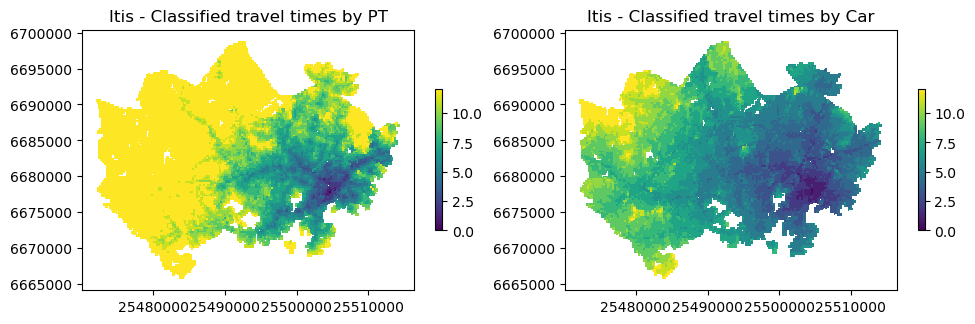

In [15]:
# Define output filename for the figure in here and use it when saving the file:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].ticklabel_format(style='plain')
axes[1].ticklabel_format(style='plain')
axes[0].set_title("Itis - Classified travel times by PT")
axes[1].set_title("Itis - Classified travel times by Car")
data_geo.plot(column="pt_r_t_cl", ax = axes[0], linewidth=0, legend=True,legend_kwds={'shrink': 0.3}, antialiased=False)
data_geo.plot(column="car_r_t_cl", ax = axes[1], linewidth=0, legend=True,legend_kwds={'shrink': 0.3}, antialiased=False)
plt.tight_layout()
output_fig1 = "itis_accessibility.png"
fig.savefig(fname=output_fig1)



In [16]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
import os
assert os.path.isfile(output_fig1), "figure does not exists!"

**Repeat the steps for Myyrmanni:**

![myyrmanni example figure](img/myyrmanni_example.png)

Next, your task is to repeat all the same steps for **Myyrmanni** (`data/TravelTimes_to_5902043_Myyrmanni.txt`):

    # Read text file using pandas into a variable called data
    # Select columns 'pt_r_t', 'car_r_t', 'from_id', 'to_id'
    # Make table join between grid and travel time data. Store output in a variable called data_geo
    # Remove no data values
    # Classify the values in columns 'pt_r_t', 'car_r_t' into new columns 'pt_r_t_cl', 'car_r_t_cl'
    # Plot travel times by public transport and travel times by car.
    # Save output image to file (myyrmanni_accessibility.png)

*Hint: You can copy paste the code from your earlier solutions in here, just change the input file path.*


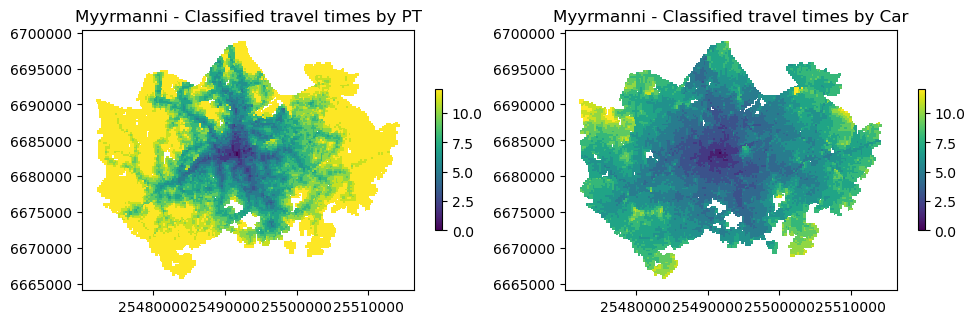

In [18]:
# Define output filename for the figure in here and use it when saving the file:
output_fig2 = "Myyrmanni_accessibility.png"

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
fd = "data/TravelTimes_to_5902043_Myyrmanni.txt"
cols = ["pt_r_t", "car_r_t", "from_id", "to_id"]
data = pd.read_csv(fd, usecols=cols, sep=";")
data_geo = grid.merge(data, how="inner", left_on="YKR_ID", right_on="from_id")
data_geo.replace(-1.,np.nan, inplace=True)
data_geo.dropna(inplace=True)
classifier = mapclassify.UserDefined.make(bins=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
data_geo[["pt_r_t_cl", "car_r_t_cl"]]= data_geo[["pt_r_t", "car_r_t"]].apply(classifier)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].ticklabel_format(style='plain')
axes[1].ticklabel_format(style='plain')
axes[0].set_title("Myyrmanni - Classified travel times by PT")
axes[1].set_title("Myyrmanni - Classified travel times by Car")
data_geo.plot(column="pt_r_t_cl", ax = axes[0], linewidth=0, legend=True,legend_kwds={'shrink': 0.3}, antialiased=False)
data_geo.plot(column="car_r_t_cl", ax = axes[1], linewidth=0, legend=True,legend_kwds={'shrink': 0.3}, antialiased=False)
plt.tight_layout()
fig.savefig(fname=output_fig2)

In [19]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
import os
assert os.path.isfile(output_fig2), "figure does not exists!"


**Optional:  4-panel figure**

As an optional task, plot travel times to Itis and Myyrmanni all in one 4-panel figure (see example at the top of this page)!

Hints:
- create a for-loop where you repeat all the steps for Itis and Myyrmanni (you can iterate over a list of input filepaths)
- Before the for-loop, create a figure with 4 subplots (2 rows and 2 columns) and use figsize=(10,10)
- Inside the for-loop, plot each map into one of the subplots. 
- save the figure as `shopping_center_accessibility.png` 

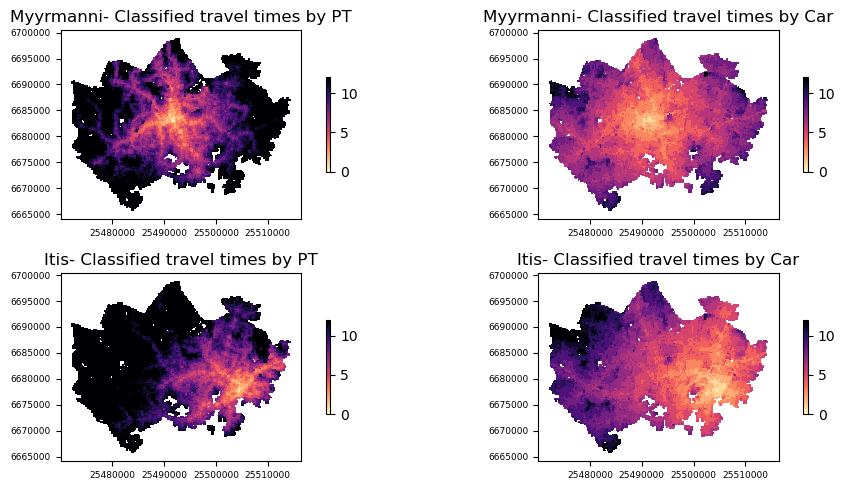

In [58]:
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# Define output filename for the figure in here and use it when saving the file:
output_fig3 = "shopping_center_accessibility.png"

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
fd = ["data/TravelTimes_to_5902043_Myyrmanni.txt", "data/TravelTimes_to_5944003_Itis.txt"]
shopping_centers = ["Myyrmanni", "Itis"]
mode = ["PT","Car"]
mode_data_names = ["pt_r_t_cl", "car_r_t_cl"]
cols = ["pt_r_t", "car_r_t", "from_id", "to_id"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5), )
for i in range(len(fd)):
    for j in range(len(fd)):
        data = pd.read_csv(fd[i], usecols=cols, sep=";")
        data_geo = grid.merge(data, how="inner", left_on="YKR_ID", right_on="from_id")
        data_geo.replace(-1.,np.nan, inplace=True)
        data_geo.dropna(inplace=True)
        classifier = mapclassify.UserDefined.make(bins=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
        data_geo[["pt_r_t_cl", "car_r_t_cl"]]= data_geo[["pt_r_t", "car_r_t"]].apply(classifier)
        axes[i][j].ticklabel_format(style='plain')
        axes[i][j].tick_params(labelsize=6.5)
        axes[i][j].set_title("{}- Classified travel times by {}".format(shopping_centers[i],mode[j]))
        data_geo.plot(column="{}".format(mode_data_names[j]), ax = axes[i][j], linewidth=0, cmap='magma_r', legend=True,legend_kwds={'shrink': 0.5}, antialiased=False)
plt.tight_layout()
fig.savefig(fname=output_fig3)

**Finally**, check that you have provided adequate comments in your code.

**Reflections:** (Only for enrolled students)
- If you want to ask feedback on spesific parts of your code, please leave your comment in here: 

YOUR ANSWER HERE

### Done!


**Remember to commit the output figures** to your exercise repository! (One for Itis and one for Myyrmanni, or optionally a combined 4-panel figure for both shopping centers and both travel modes).

That's it! Once you have plotted the data and saved the output you are ready to continue with Problem 2.